# Dry Bean

This dataset is from [UCI Machine Learning Repository](https://archive-beta.ics.uci.edu/ml/datasets/dry+bean+dataset).

The images of 13,611 grains of 7 different registered dry beans were taken with a high-resolution camera wtih a total of 16 features. This is a relatively high amount of instances to learn from and it will interesting to see how different classifiers deal with overfitting and could be a great experiment to prove that boosting algorithms don't overfit and the more data it's fed, the better it performs.

From the paper related with the dataset, all different types of beans but the Barbuya kind all have white colors and the only visual queue that can help distinguishing them are some physical hints which sometimes are quite deceiving still to the human eyes. Because of this, it will be inteseting to see how different classifiers perform with a dataset that has a relative high variance in the features.

According to the label distribution, the dataset is not perfectly balanced. It has a relatively low amount of data on Barunya and Bombay kind but a realtively high amount of data on Dermason kind. It will be interesting to see if that means Barunya and Bomaby will be categorized poorly whereas Dermason will be categorized well.


In [1]:
%config IPCompleter.greedy = True
%config IPCompleter.use_jedi = True

## Setup

First, we load all the packages required for running the five algorithms and analyzing their performance.


In [2]:
import time

import numpy as np
import pandas as pd
import seaborn as sns
import category_encoders as ce
import matplotlib.pyplot as plt

from sklearn import base
from sklearn import preprocessing
from sklearn import svm
from sklearn import tree

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from scipy.io import arff

from typing import Any
from typing import Union

import warnings
warnings.filterwarnings('ignore')

## Data Preprocessing



This dataset from UCI Data Repository has already been cleaned up and has no unknown values.

- Use the `preprocessing.OrdinalEncoder` module to encode the **Class** column
- Scale the features
- Split the data into **Training** and **Test** sets (70% and 30% respectively)


In [3]:
data = pd.DataFrame(arff.loadarff('data/Dry_Bean_Dataset.arff')[0])

features = preprocessing.scale(data.drop(['Class'], axis=1))
target = data["Class"]

print(f"Number of samples: {target.size}")
print(
    f"Percentage of SEKER: {target.value_counts(normalize=True)[b'SEKER'] * 100:.3f}%")
print(
    f"Percentage of BARBUNYA: {target.value_counts(normalize=True)[b'BARBUNYA'] * 100:.3f}%")
print(
    f"Percentage of BOMBAY: {target.value_counts(normalize=True)[b'BOMBAY'] * 100:.3f}%")
print(
    f"Percentage of CALI: {target.value_counts(normalize=True)[b'CALI'] * 100:.3f}%")
print(
    f"Percentage of HOROZ: {target.value_counts(normalize=True)[b'HOROZ'] * 100:.3f}%")
print(
    f"Percentage of SIRA: {target.value_counts(normalize=True)[b'SIRA'] * 100:.3f}%")
print(
    f"Percentage of DERMASON: {target.value_counts(normalize=True)[b'DERMASON'] * 100:.3f}%")

data["Class"] = preprocessing.OrdinalEncoder().fit_transform(data[["Class"]])
target = data["Class"]

print("Splitting into train/test sets...", end="")
FEATURES_TRAIN, FEATURES_TEST, TARGET_TRAIN, TARGET_TEST = train_test_split(
    features, target, test_size=0.3, random_state=42)
print("Done")

print("Setting up global variables...", end="")
classifier_accuracy = np.zeros(6)
train_time = np.zeros(6)
infer_time = np.zeros(6)
print("Done")


Number of samples: 13611
Percentage of SEKER: 14.892%
Percentage of BARBUNYA: 9.713%
Percentage of BOMBAY: 3.835%
Percentage of CALI: 11.976%
Percentage of HOROZ: 14.165%
Percentage of SIRA: 19.367%
Percentage of DERMASON: 26.052%
Splitting into train/test sets...Done
Setting up global variables...Done


## Helper Functions & Global Variables


In [4]:
TARGET_CLASSES = ['BARBUNYA', 'BOMBAY', 'CALI', 'DERMASON', 'HOROZ', 'SEKER', 'SIRA']


def plot_confusionmatrix(predicted, expected, dom) -> None:
    print(f'{dom} Confusion matrix')
    cf = confusion_matrix(predicted, expected)
    sns.heatmap(cf, annot=True, yticklabels=TARGET_CLASSES,
                xticklabels=TARGET_CLASSES, cmap='Blues', fmt='g')
    plt.tight_layout()
    plt.show()


In [5]:
ClassifierMixin = Union[DecisionTreeClassifier, MLPClassifier,
                        AdaBoostClassifier, SVC, KNeighborsClassifier]


def default_fit_test(classifier: ClassifierMixin) -> None:
    classifier.fit(FEATURES_TRAIN, TARGET_TRAIN)

    train_pred = classifier.predict(FEATURES_TRAIN)
    test_pred = classifier.predict(FEATURES_TEST)

    print(f'Train score {accuracy_score(train_pred, TARGET_TRAIN)}')
    print(f'Test score {accuracy_score(test_pred, TARGET_TEST)}')
    plot_confusionmatrix(train_pred, TARGET_TRAIN, dom='Train')
    plot_confusionmatrix(test_pred, TARGET_TEST, dom='Test')


In [6]:
def grid_search_and_best_fit(classifier: ClassifierMixin, param_grid: dict[str, Any], index: int, name: str) -> GridSearchCV:
    classifier_best = GridSearchCV(
        classifier, param_grid=param_grid, cv=4)

    start_time = time.time()
    classifier_best.fit(FEATURES_TRAIN, TARGET_TRAIN)
    end_time = time.time()
    train_time[index] = end_time - start_time
    print(f"Best params for {name}: {classifier_best.best_params_}")

    return classifier_best


In [7]:
def best_fit_test(classifier_best: GridSearchCV, index: int, name: str) -> None:
    best_train_pred = classifier_best.predict(FEATURES_TRAIN)
    print(
        f"Accuracy for best {name} on train sets: {accuracy_score(TARGET_TRAIN, best_train_pred)}")
    start_time = time.time()
    best_test_pred = classifier_best.predict(FEATURES_TEST)
    classifier_accuracy[index] = accuracy_score(TARGET_TEST, best_test_pred)
    end_time = time.time()
    infer_time[index] = end_time - start_time
    print(
        f"Accuracy for best {name} on test sets: {classifier_accuracy[index]}")

    plot_confusionmatrix(best_train_pred, TARGET_TRAIN,
                         dom="Train Set with Best Params")
    plot_confusionmatrix(best_test_pred, TARGET_TEST,
                         dom="Test Set with Best Params")


In [8]:
def plot_learning_curve(classifier_learning: ClassifierMixin, name: str):
    _, train_scores, val_scores = learning_curve(
        classifier_learning, FEATURES_TRAIN, TARGET_TRAIN, train_sizes=np.linspace(0.1, 1.0, 10), cv=4)

    plt.figure()
    plt.plot(np.linspace(0.1, 1.0, 10)*100,
             np.mean(train_scores, axis=1), label='Train Score')
    plt.plot(np.linspace(0.1, 1.0, 10)*100,
             np.mean(val_scores, axis=1), label='CV Score')
    plt.legend()
    plt.title(f"Learning Curve ({name})")
    plt.xlabel("Percentage of Training Examples")
    plt.ylabel("Score")
    plt.xticks(np.linspace(0.1, 1.0, 10) * 100)
    plt.grid()
    plt.savefig(
        f"images/dry_bean/dry_bean_{'_'.join(name.lower().split(' '))}_learning_curve.png")
    plt.show()


In [9]:
def plot_validation_curve(
        classifier: ClassifierMixin, param_name: str,
        param_range: np.ndarray, name: str,
        xticks: np.ndarray = None, default_xticks: bool = False,
        xaxis_log: bool = False) -> None:
    train_scores, val_scores = validation_curve(
        classifier, FEATURES_TRAIN, TARGET_TRAIN, param_name=param_name, param_range=param_range, cv=4)

    plt.figure()
    if xaxis_log:
        plt.semilogx(param_range, np.mean(train_scores, axis=1), label='Train Score')
        plt.semilogx(param_range, np.mean(val_scores, axis=1), label='CV Score')
    else:
        plt.plot(param_range, np.mean(train_scores, axis=1), label='Train Score')
        plt.plot(param_range, np.mean(val_scores, axis=1), label='CV Score')
    plt.legend()
    plt.title(f"Validation Curve ({name})")
    plt.xlabel(param_name)
    plt.ylabel("Score")
    if default_xticks:
        pass
    elif xticks is not None:
        plt.xticks(xticks)
    else:
        plt.xticks(param_range)
    plt.grid()
    plt.savefig(
        f"images/dry_bean/dry_bean_{'_'.join(name.lower().split(' '))}_{param_name}_validation_curve.png")
    plt.show()


`scikit-learn` provides an extremely intuitive interface for training and evaluating machine learning models. I will be using `validation_curve` and `GridSearchCV` to cross-validate over a range of hyper-parameter values to find the best model.


## Decision Tree


### Pretuning


Train score 1.0
Test score 0.888099902056807
Train Confusion matrix


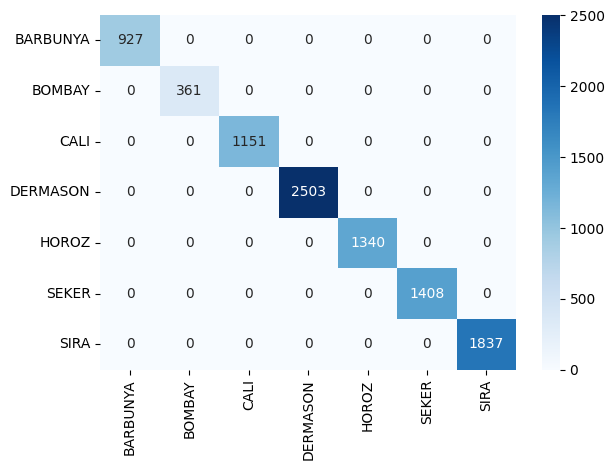

Test Confusion matrix


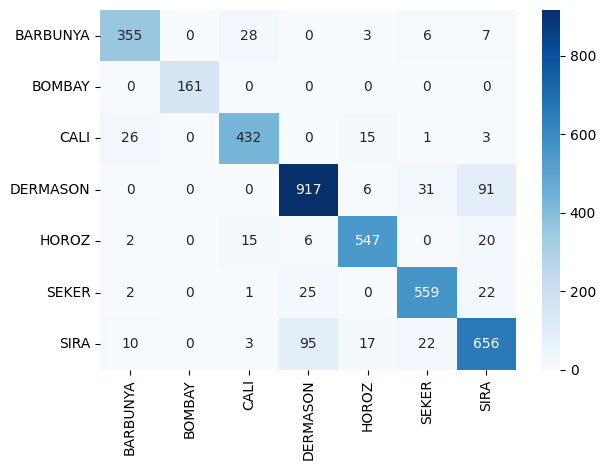

In [18]:
decision_tree_classifier = DecisionTreeClassifier(random_state=42)
default_fit_test(decision_tree_classifier)


The above figures are the confusion matricies on the training set and testing set respectively of a Decision Tree Classifier with no pruning and no parameter tuning. The decision tree classifier can get 100% correct on the training set but merely 88% for the test set. This is a clear sign of overfitting. The decision tree is too complex and is not generalizing well.


### Tuning Maximum Depth and CCP-$\alpha$


To prevent over fitting, a maximum depth will be set as a pre-pruning method and CCP-$\alpha$ (Cost Complexity Pruning) will be used for post-pruning.

Two parameters will be tuned:

- `max_depth` for the tree maxium depth ranging from [1, 35)
- regularization parameter $\alpha$ for CCP ranging from [0, 0.035). A higher value of $\alpha$ will prune more nodes out of the tree.


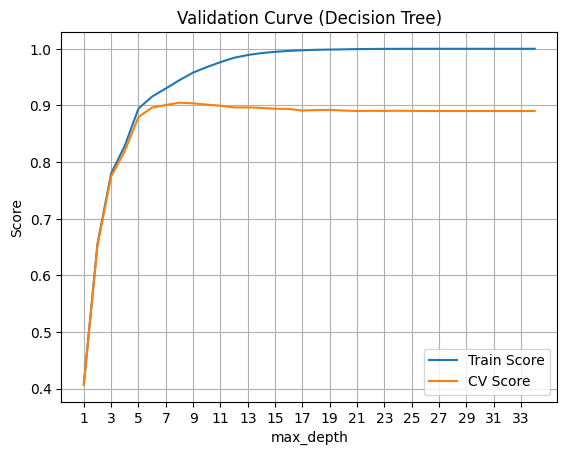

In [19]:
plot_validation_curve(
    decision_tree_classifier, 'max_depth',
    np.arange(1, 35), 'Decision Tree',
    np.arange(1, 35, 2))


The above figure is a cross-validation graph for `max_depth`. The training score converges to 1 as the maximum depth increases as the tree is getting more and more complex and can fit the training data perfectly. However, the validation score reaches its peak at a certain value and starts decreasing as overfitting starts kicking in.


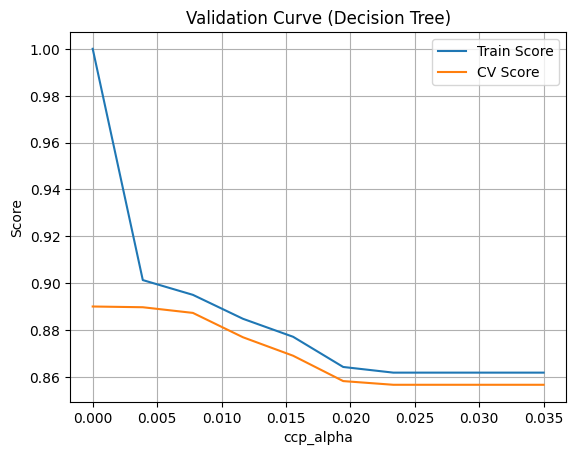

In [20]:
plot_validation_curve(
    decision_tree_classifier, 'ccp_alpha',
    np.linspace(0, 0.035, 10), 'Decision Tree',
    np.linspace(0, 0.035, 8))


With an incresing CCP-$\alpha$, both the training score and the corss validation score decrease. This means with the current dataset, no nodes should be pruned out using the Cross Complexity Pruning algorithm.


In [21]:
param_grid = {
    'max_depth': np.arange(1, 35),
    'ccp_alpha': np.linspace(0, 0.035, 10)
}
decision_tree_classifier_best = grid_search_and_best_fit(
    decision_tree_classifier, param_grid, 0, "decision tree")


Best params for decision tree: {'ccp_alpha': 0.0, 'max_depth': 8}


Accuracy for best decision tree on train sets: 0.939225359504566
Accuracy for best decision tree on test sets: 0.9005876591576886
Train Set with Best Params Confusion matrix


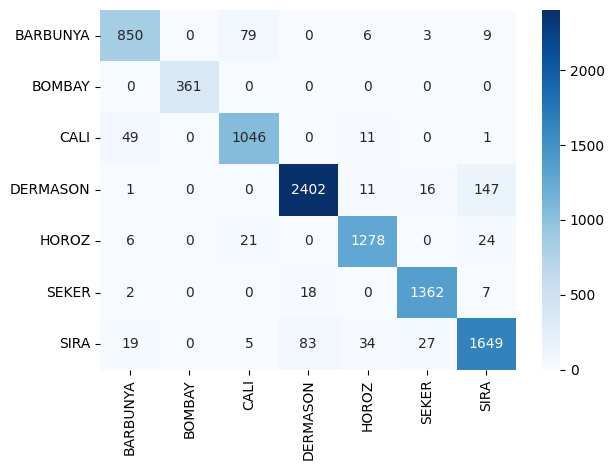

Test Set with Best Params Confusion matrix


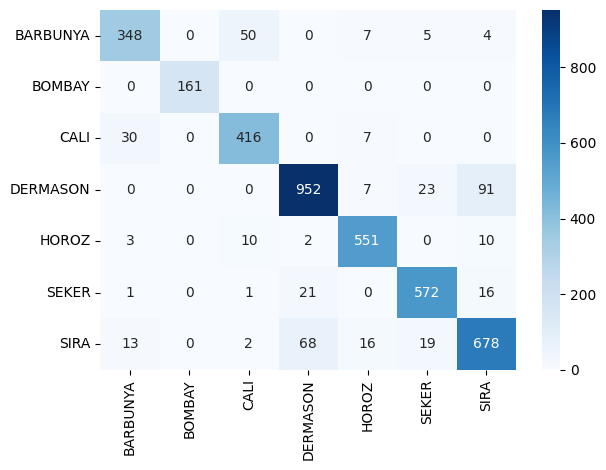

In [22]:
best_fit_test(decision_tree_classifier_best, 0, "decision tree")


The above figures are the confusion matricies of the Decision Tree classifier with the best parameter according to the grid search. The accuracy score for the training set is not 100% anymore but the accuracy score for the testing set is improved by 2%.

The fact that the accruacy score for both testing set and training set are not high tells me that the dataset I have chosen could be noisy.

From the confusion matrix, the model is struggling to distinguish betwen Demarson and Sira. One explanation is that the attirbutes corresponding to those 2 categories are rather similar.


### Deicision Tree Learning Curve


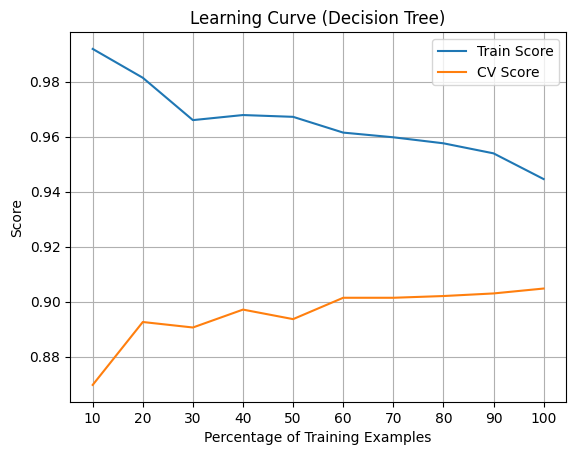

In [23]:
decision_tree_classifier_learning = DecisionTreeClassifier(
    random_state=42,
    max_depth=decision_tree_classifier_best.best_params_['max_depth'],
    ccp_alpha=decision_tree_classifier_best.best_params_['ccp_alpha']
)
plot_learning_curve(decision_tree_classifier_learning, "Decision Tree")


The trend of convergence between the training score and the corss validation score is observed from the above figure with the increasing percentage of training examples.

However, the gap is still relatively big when it reaches 100%. This shows that either the data is quite noisy or we need more data to establish a more complex model to increase the performance. However, given that there are already 13.61k instances in the dataset, a noisy dataset seems to be a more likely explanation.


## Neural Networks


### Multi-Layer Neural Network


#### Pretuning


Train score 0.9249501417025296
Test score 0.9211557296767875
Train Confusion matrix


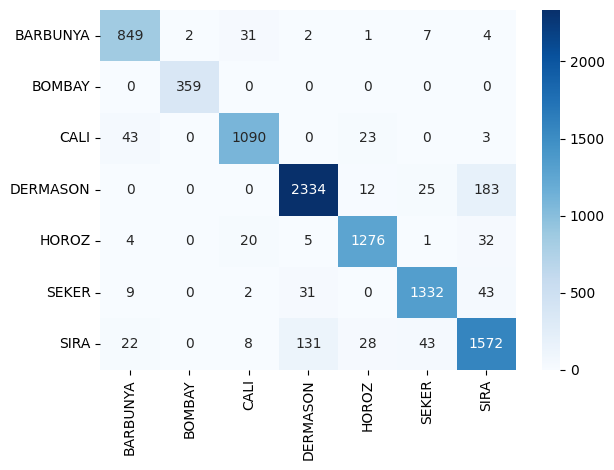

Test Confusion matrix


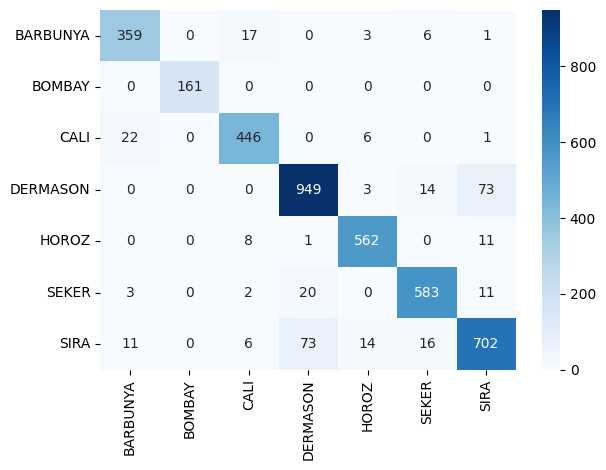

In [10]:
neural_network_classifier = MLPClassifier(
    hidden_layer_sizes=(4, 4),
    random_state=42,
    max_iter=2000
)
default_fit_test(neural_network_classifier)


For the multi-layer neural network, a neural network with 2 4-node hidden layers is established. The activation function is ReLU and the solver is Adam. Compared to the decision tree, the multi-layer neural network is already performing better.


#### Tuning Regularization $\alpha$ and Initial Learning Rate


Two parameters will be tuned:

- regularization parameter $\alpha$ for L2 regularization ranging from $[10^{-20}, 10^1)$.
- initial learning rate for the Adam optimizer ranging from [0.0001, 0.1)


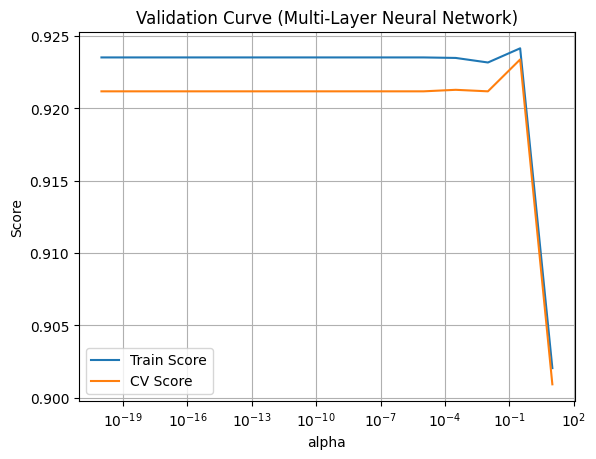

In [25]:
plot_validation_curve(
    neural_network_classifier, 'alpha',
    np.logspace(-20, 1, 15), "Multi-Layer Neural Network",
    default_xticks=True, xaxis_log=True)


Regularization adds the penalty as model complexity increases. The regularization parameter forces the weights to be small but does not make them zero and does not give the sparse solution to avoid overfitting. However, as the value gets bigger, it will lead to under-fitting. When alpha is 0, ridge regularization is equivalent to ordinary least squre ot OLS.

The above figure shows the underfitting nicely as both the training scores and the CV score starts to plummet as $\alpha$ exceeds a certain value.


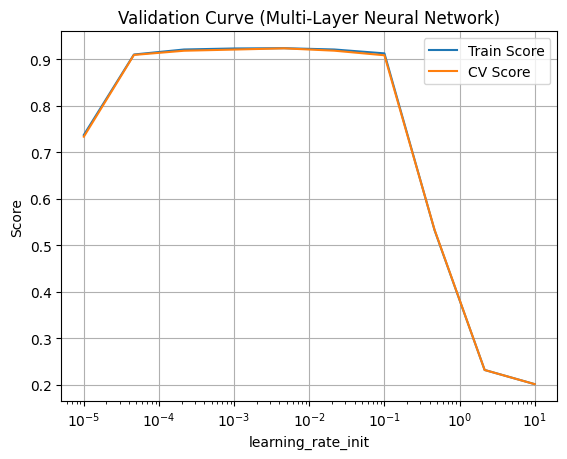

In [26]:
plot_validation_curve(
    neural_network_classifier, 'learning_rate_init',
    np.logspace(-5, 1, 10), "Multi-Layer Neural Network",
    default_xticks=True, xaxis_log=True)


The above figure can be separated into three different sections and they corresponds to the three differnt init learning rate period.

Just like gradient descent if the learning rate is too small, it will take a lot of iterations to find the local optimum. With a maximum of iterations set for the MLPClassifier, it's likely the model is not well-trained. This corresponds to the first section of the graph when the training score and CV score increases at the same time.

When the learning rate is just right, the model can be trained well within the iteration limit. This corresponds to the plateau of the graph.

However, when the learning rate is too big, drastic update can lead tp divergent behaviour which will lower the accuracy score. This corresponds to the third section of the graph when the training score and CV score starts to plummet.


In [11]:
param_grid = {
    'alpha': np.logspace(-20, 1, 15),
    'learning_rate_init': np.logspace(-5, 1, 10)
}
neural_network_classifier_best = grid_search_and_best_fit(
    neural_network_classifier, param_grid, 1, "multi-layer neural network")


Best params for multi-layer neural network: {'alpha': 1e-20, 'learning_rate_init': 0.004641588833612777}


Accuracy for best multi-layer neural network on train sets: 0.9236905636611735
Accuracy for best multi-layer neural network on test sets: 0.9236043095004897
Train Set with Best Params Confusion matrix


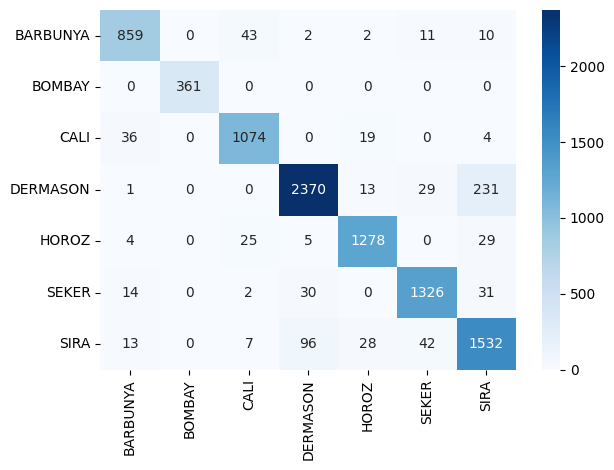

Test Set with Best Params Confusion matrix


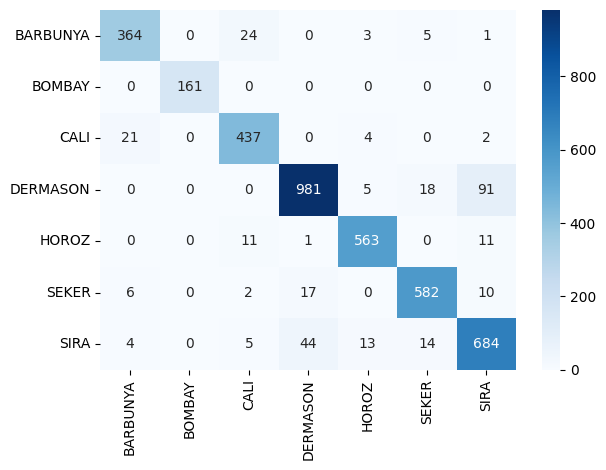

In [28]:
best_fit_test(neural_network_classifier_best, 1, "multi-layer neural network")


Compared to Decision Tree Classifier, the multi-layer neural network does better at classifying Demarson but performs as poorly as the decision tree classifier at classifying Sira.

Comparing the accuracy score on the testing set between the default neural network and the best parameter neural network, improvement can be found but not significant. This is likely due to the fact that the dataset I have chosen is a bit noisy,


#### Neural Network Learning Curve


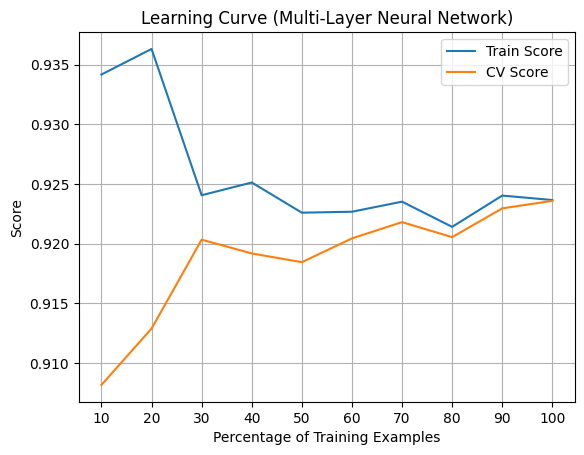

In [29]:
neural_network_classifier_learning = MLPClassifier(
    hidden_layer_sizes=(4, 4), random_state=42, max_iter=2000,
    learning_rate_init=neural_network_classifier_best.best_params_['learning_rate_init'],
    alpha=neural_network_classifier_best.best_params_['alpha'])
plot_learning_curve(neural_network_classifier_learning,
                    "Multi-Layer Neural Network")


From the above learning curve, it shows a strong trend of convergence at a low percentage of trainign exmaples. This likely means that the dataset has low variance and low bias. At a higher percentage of trainig examples, the small gap between the trianing score and the CV score shows that the neural network is a good fit for this particular dataset. This also suggests that the dataset is linearly separable.


### Training Loss and Score


Using the same hyper parameter, the loss curve which shows how error is reduced as the epochs keeps increasing during training is also plotted for the training set.


In [12]:
neural_network_classifier = MLPClassifier(
    hidden_layer_sizes=(4, 4), random_state=42, max_iter=1  ,
    alpha=neural_network_classifier_best.best_params_['alpha'],
    learning_rate_init=neural_network_classifier_best.best_params_['learning_rate_init'],
    warm_start=True
)
epochs = 300
training_loss = np.zeros(epochs)
validation_loss = np.zeros(epochs)
training_score = np.zeros(epochs)
validation_score = np.zeros(epochs)

features_train_train, features_train_val, target_train_train, target_train_val = train_test_split(
    FEATURES_TRAIN, TARGET_TRAIN, test_size=0.3, random_state=42)
for epoch in range(epochs):
    neural_network_classifier.fit(features_train_train, target_train_train)

    training_score[epoch] = accuracy_score(
        target_train_train, neural_network_classifier.predict(features_train_train))
    training_loss[epoch] = neural_network_classifier.loss_

    validation_score[epoch] = accuracy_score(
        target_train_val, neural_network_classifier.predict(features_train_val))
    validation_loss[epoch] = neural_network_classifier.loss_


test_score = accuracy_score(
    TARGET_TEST, neural_network_classifier.predict(FEATURES_TEST))
print("Test set accuracy:", test_score)


Test set accuracy: 0.9272771792360431


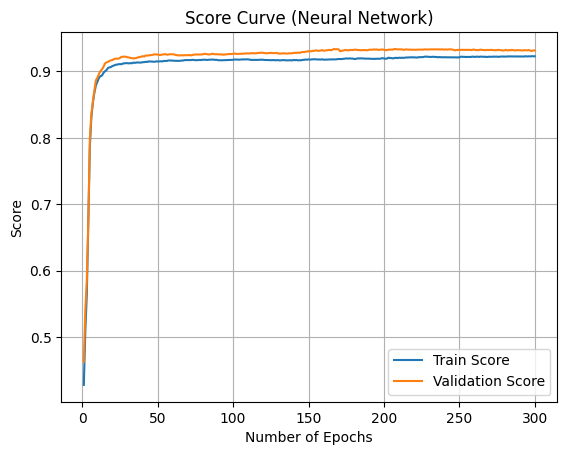

In [13]:
plt.figure()
plt.plot(np.arange(epochs) + 1, training_score, label='Train Score')
plt.plot(np.arange(epochs) + 1, validation_score, label='Validation Score')
plt.legend()
plt.title("Score Curve (Neural Network)")
plt.xlabel("Number of Epochs")
plt.ylabel("Score")
plt.grid()
plt.savefig('images/dry_bean/dry_bean_neural_network_score_curve.png')
plt.show()


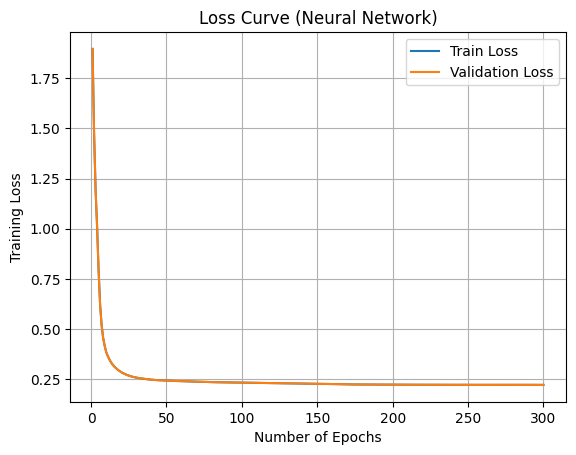

In [15]:
plt.figure()
plt.plot(np.arange(epochs) + 1, training_loss, label='Train Loss')
plt.plot(np.arange(epochs) + 1, validation_loss, label='Validation Loss')
plt.legend()
plt.title("Loss Curve (Neural Network)")
plt.xlabel("Number of Epochs")
plt.ylabel("Training Loss")
plt.grid()
plt.savefig('images/dry_bean/dry_bean_neural_network_loss_curve.png')
plt.show()


The training loss keeps decreasing with increasing number of epochs as expected from the network. The smooth curve and the rate of decrement shows that the neural network is a good fit. The high training and validation scores also supports this conclusion.


### Single-Layer Neural Network


#### Pretuning


Train score 0.9393303243413457
Test score 0.933643486777669
Train Confusion matrix


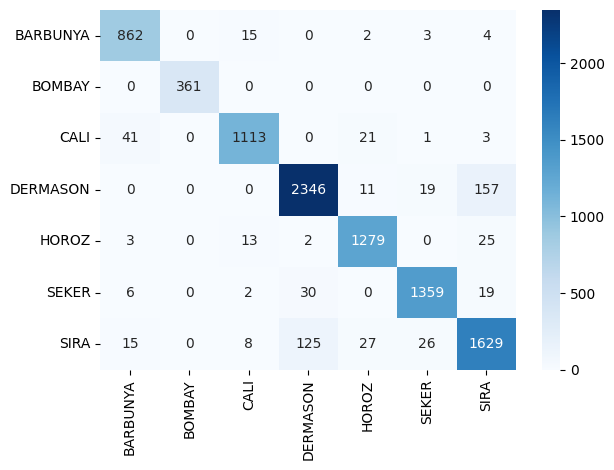

Test Confusion matrix


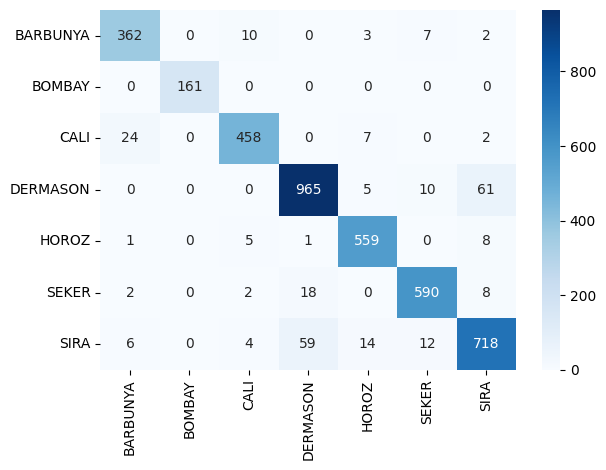

In [33]:
neural_network_classifier = MLPClassifier(random_state=42, max_iter=2000)
default_fit_test(neural_network_classifier)


Here I established a base case for a single-layer neural network. In this case the neural network will only have 1 layer but there will be multiple neurons on that layer.


#### Tuning Regularization $\alpha$ and Hidden Layer Sizes


Two parameters will be tuned:

- regularization parameter $\alpha$ for L2 regularization ranging from $[10^{-20}, 10^1)$.
- hidden layer sizes ranging from [2, 31]


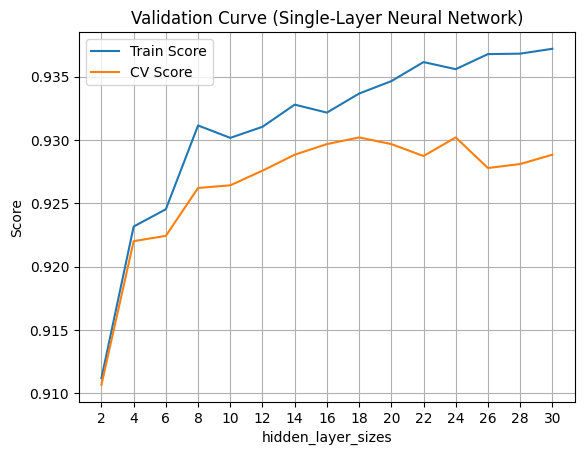

In [34]:
plot_validation_curve(
    neural_network_classifier, 'hidden_layer_sizes',
    np.arange(2, 31, 2), "Single-Layer Neural Network")


From the above validation curve, the training score and the CV score start to diverge from each other as the hidden layer size increases and the CV score starts to decrease after a certain point. This is a sign of overfitting. The model is getting too complex and is not generalizing well.


In [35]:
param_grid = {
    'alpha': np.logspace(-20, 1, 15),
    'hidden_layer_sizes': np.arange(2, 31, 2)
}
neural_network_classifier_best = grid_search_and_best_fit(
    neural_network_classifier, param_grid, 2, "single layer neural network")


Best params for single layer neural network: {'alpha': 0.01, 'hidden_layer_sizes': 24}


Accuracy for best single layer neural network on train sets: 0.9357615198908366
Accuracy for best single layer neural network on test sets: 0.933643486777669
Train Set with Best Params Confusion matrix


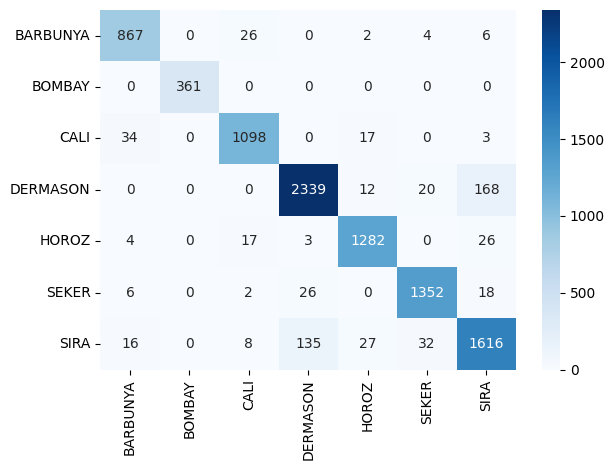

Test Set with Best Params Confusion matrix


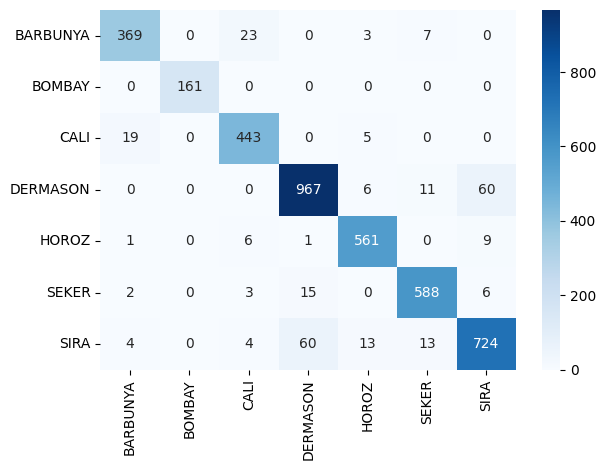

In [36]:
best_fit_test(neural_network_classifier_best, 2, "single layer neural network")


Surprisingly, the single-layer neural network actually does better than the multi-layer nerual network. Normally, a multi-layer neural network can introduce more non-linearity than a single-layer neural network can and thus should perform better with more complex data. One possible reason is that the dataset is extremely biased towards linear relationship. This also suggest that hte dataset is linearly seperable.


#### Nerual Network Learning Curve


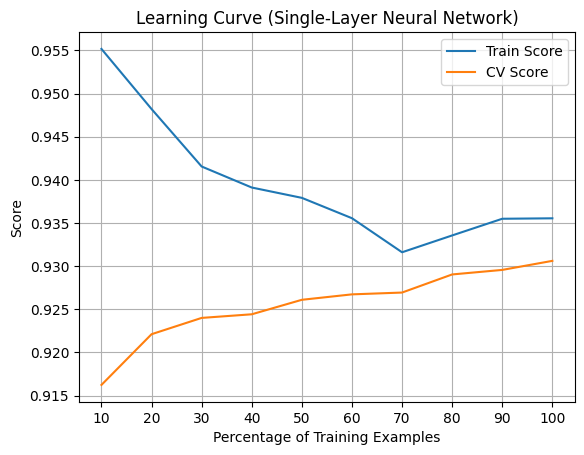

In [37]:
neural_network_classifier_learning = MLPClassifier(
    random_state=42, max_iter=2000,
    hidden_layer_sizes=neural_network_classifier_best.best_params_['hidden_layer_sizes'],
    alpha=neural_network_classifier_best.best_params_['alpha'])
plot_learning_curve(neural_network_classifier_learning,
                    "Single-Layer Neural Network")


The learning curve of the single-layer neural network does not show as a strong trend of convergence as early as the multi-layer neural network does but the final value they converge on is higher comapred to the multi-layer network. 

This shows that the single-layer neural network is a better fit for this dataset.


## Boosting


### Pretuning


Train score 0.864385430880655
Test score 0.85871694417238
Train Confusion matrix


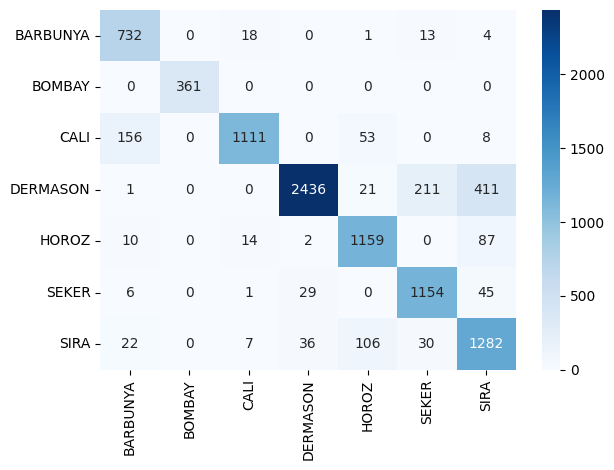

Test Confusion matrix


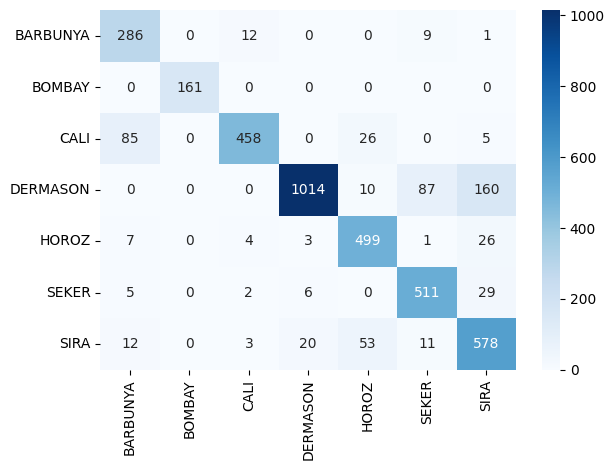

In [62]:
adaboost_classifier = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(
    max_depth=3, min_samples_leaf=1), random_state=42)
default_fit_test(adaboost_classifier)


The boosting classifier uses decision tree with a max_depth of 3 as a weak learner. The max depth of 3 is determined by $\left \lceil log_25 \right \rceil$.


### Tuning N-Estimators and Learning Rate


Parameters to be tuned:

- n_estimators ranging from [1, 300]
- learning rate ranging from $[10^{-5}, 10)$


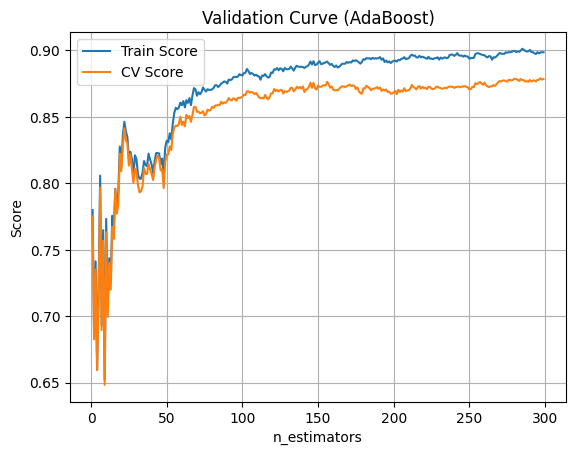

In [63]:
plot_validation_curve(
    adaboost_classifier, 'n_estimators',
    np.arange(1, 300), "AdaBoost",
    default_xticks=True)


The figure above is quite interesting where both the CV score and the train score oscillates when the number of weak learner is low. It almost feels like the weak learner learned one "hard" instance but got it wrong again on the previous "hard" instance. This makes sense as with lower number of weak learners, the less grabulairty the classifier has on the weight distirbution which can lead to divergent behaviour.

When the number of weak learner gets higher, the score stabalizes, but still with some minor oscillation. This suggests that the dataset can be noisy.


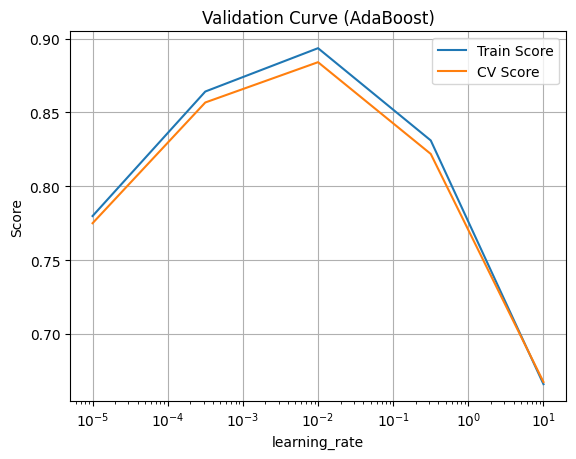

In [64]:
plot_validation_curve(
    adaboost_classifier, 'learning_rate',
    np.logspace(-5, 1, 5), "AdaBoost",
    default_xticks=True, xaxis_log=True)


The learning rate validation curve is similar to the `learning_rate_init` validation curve from the neural network. Since boosting also uses methods similar to gradient descent to approach the local optima, the three different sections of the graph corresponds to the three different learning rate period are also observed from the graph.


In [65]:
param_grid = {
    'learning_rate': np.logspace(-5, 1, 5),
    'n_estimators': np.arange(1, 300)
}
adaboost_classifier_best = grid_search_and_best_fit(
    adaboost_classifier, param_grid, 3, "adaboost")


Best params for adaboost: {'learning_rate': 0.01, 'n_estimators': 41}


Accuracy for best adaboost on train sets: 0.8911514642594731
Accuracy for best adaboost on test sets: 0.8844270323212536
Train Set with Best Params Confusion matrix


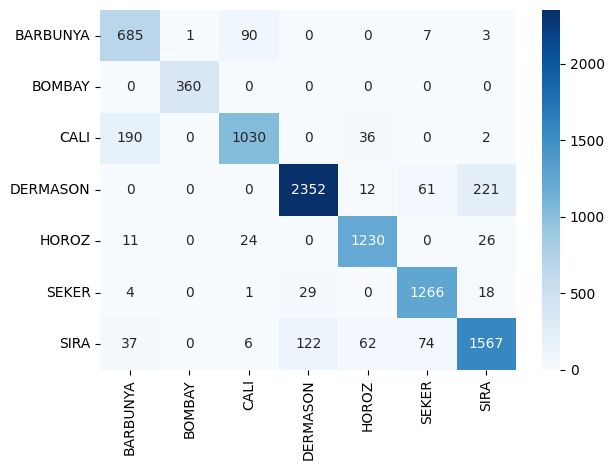

Test Set with Best Params Confusion matrix


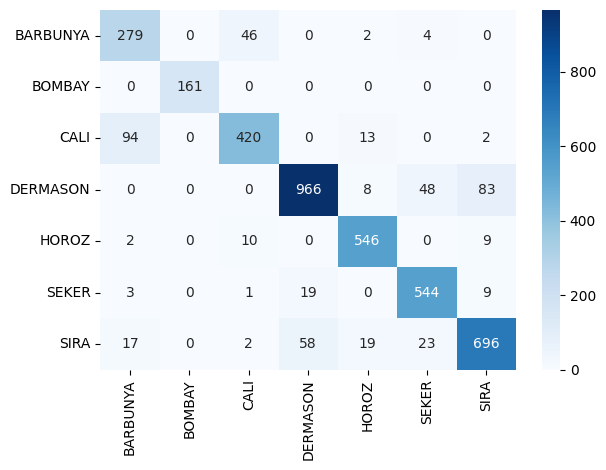

In [66]:
best_fit_test(adaboost_classifier_best, 3, "adaboost")


### Adaboost Learning Curve


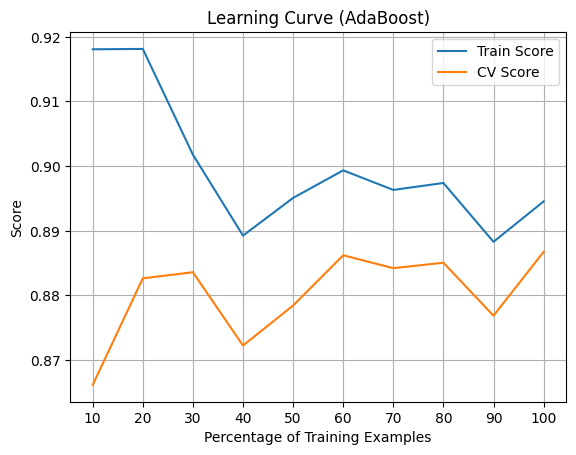

In [74]:
adaboost_classifier_learning_curve = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(
    max_depth=3, min_samples_leaf=1), random_state=42,
    n_estimators=adaboost_classifier_best.best_params_['n_estimators'],
    learning_rate=adaboost_classifier_best.best_params_['learning_rate'])
plot_learning_curve(adaboost_classifier_learning_curve, "AdaBoost")


The learning curve for the Adaboost shows a trend of convergence. Howver, the final accuracy score is not great. This shows that the weak learners need to be more complicated (increasing the max_dpeth size in this case) to improve the performance of the Adaboost classifier. This speculation can be supported by the fact that the Decision Tree Classifier requries a max_dpeth of 8 to have an over 90% accuracy score.


## SVM


### Pretuning


Train score 0.9279941219691403
Test score 0.9260528893241919
Train Confusion matrix


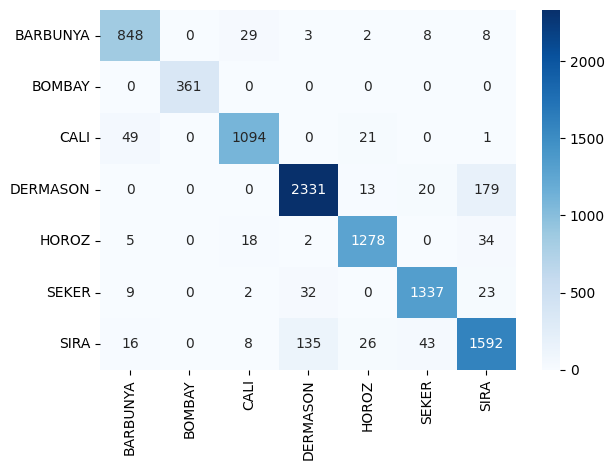

Test Confusion matrix


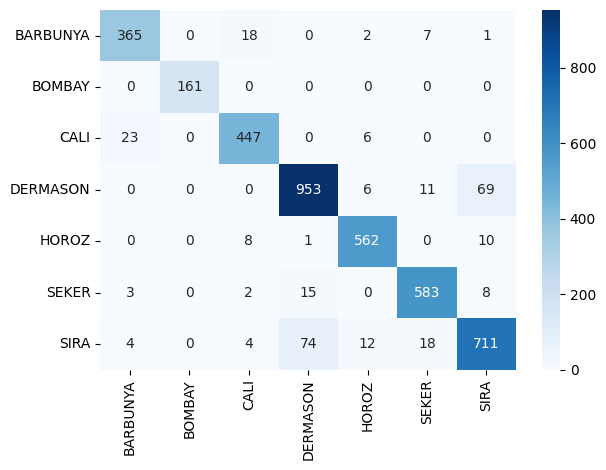

In [44]:
svm_classifier = SVC(kernel='linear', random_state=42)
default_fit_test(svm_classifier)


With default setup, the SVM classifier uses an rbf kernel and a C value of 1.0. The SVC with default setup can achieve an accruacy score of 92.8%. However, just like the other classifiers, the SVC also struggles to classify Demarson and Sira.

### Tuning Regularization C and Kernel Method


Parameters to be tuned:

- C ranging from $[1, 10^{1.5})$
- kernel method ranging from ['linear', 'poly', 'rbf', 'sigmoid']


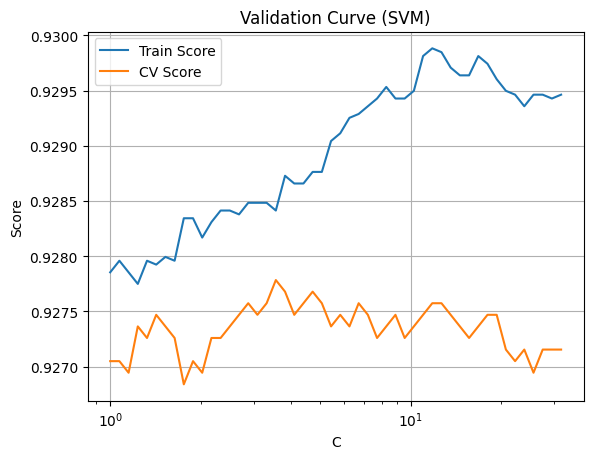

In [45]:
plot_validation_curve(
    svm_classifier, 'C',
    np.logspace(0, 1.5), "SVM",
    default_xticks=True, xaxis_log=True)


The C parameter tells the SVM optimization how much you want to avoid misclassifying each training example. For large values of C, the optimization will choose a smaller-margin hyperplane if that hyperplane does a better job of getting all the training points classified correctly which can lead to overfitting. Conversely, a very small value of C will cause the optimizer to look for a larger-margin separating hyperplane, even if that hyperplane misclassifies more points which can lead to underfitting.

Both trends can be observed in the above graph. After a certain point, the CV score begins to decrease while the training score is still in an upward trajectory.


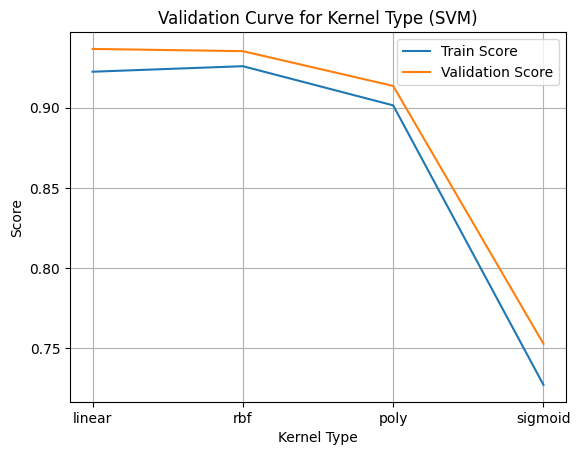

In [46]:
train_scores = np.zeros((4, 1))
test_scores = np.zeros((4, 1))

svm_classifier = svm.SVC(random_state=42, kernel='linear')
features_train_train, features_train_test, target_train_train, target_train_test = train_test_split(
    FEATURES_TRAIN, TARGET_TRAIN, test_size=0.3, random_state=42)
svm_classifier.fit(features_train_train, target_train_train)
train_scores[0] = accuracy_score(
    target_train_train, svm_classifier.predict(features_train_train))
test_scores[0] = accuracy_score(
    target_train_test, svm_classifier.predict(features_train_test))

svm_classifier = svm.SVC(random_state=42, kernel='rbf')
features_train_train, features_train_test, target_train_train, target_train_test = train_test_split(
    FEATURES_TRAIN, TARGET_TRAIN, test_size=0.3, random_state=42)
svm_classifier.fit(features_train_train, target_train_train)
train_scores[1] = accuracy_score(
    target_train_train, svm_classifier.predict(features_train_train))
test_scores[1] = accuracy_score(
    target_train_test, svm_classifier.predict(features_train_test))

svm_classifier = svm.SVC(random_state=42, kernel='poly')
features_train_train, features_train_test, target_train_train, target_train_test = train_test_split(
    FEATURES_TRAIN, TARGET_TRAIN, test_size=0.3, random_state=42)
svm_classifier.fit(features_train_train, target_train_train)
train_scores[2] = accuracy_score(
    target_train_train, svm_classifier.predict(features_train_train))
test_scores[2] = accuracy_score(
    target_train_test, svm_classifier.predict(features_train_test))

svm_classifier = svm.SVC(random_state=42, kernel='sigmoid')
features_train_train, features_train_test, target_train_train, target_train_test = train_test_split(
    FEATURES_TRAIN, TARGET_TRAIN, test_size=0.3, random_state=42)
svm_classifier.fit(features_train_train, target_train_train)
train_scores[3] = accuracy_score(
    target_train_train, svm_classifier.predict(features_train_train))
test_scores[3] = accuracy_score(
    target_train_test, svm_classifier.predict(features_train_test))

plt.figure()
plt.plot(np.arange(0, 4), np.mean(train_scores, axis=1), label='Train Score')
plt.plot(np.arange(0, 4), np.mean(
    test_scores, axis=1), label='Validation Score')
plt.legend()
plt.title("Validation Curve for Kernel Type (SVM)")
plt.xlabel("Kernel Type")
plt.ylabel("Score")
plt.grid()
plt.xticks(np.arange(4), ['linear', 'rbf', 'poly', 'sigmoid'])
plt.savefig('images/dry_bean/dry_bean_svm_kernel_validation_curve.png')
plt.show()


Among the four kernel methods, the linear kernel performs the best according to the validation curve. This implies that the dataset may be linearly separable.


In [47]:
param_grid = {
    'C': np.logspace(0, 1.5),
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid']
}
svm_classifier_best = grid_search_and_best_fit(
    svm_classifier, param_grid, 4, "SVM")


Best params for SVM: {'C': 20.716983998953076, 'kernel': 'rbf'}


Accuracy for best SVM on train sets: 0.9400650781988034
Accuracy for best SVM on test sets: 0.932664054848188
Train Set with Best Params Confusion matrix


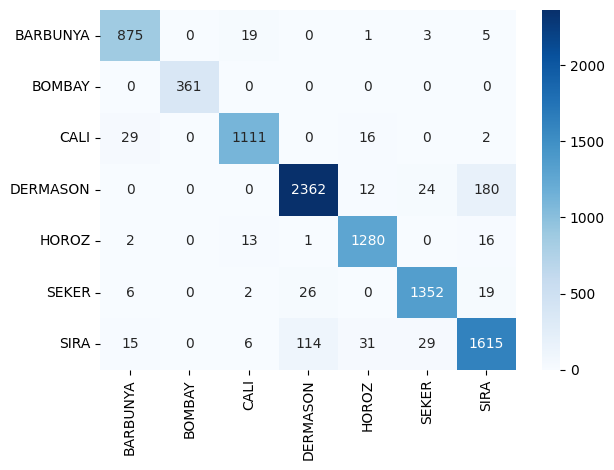

Test Set with Best Params Confusion matrix


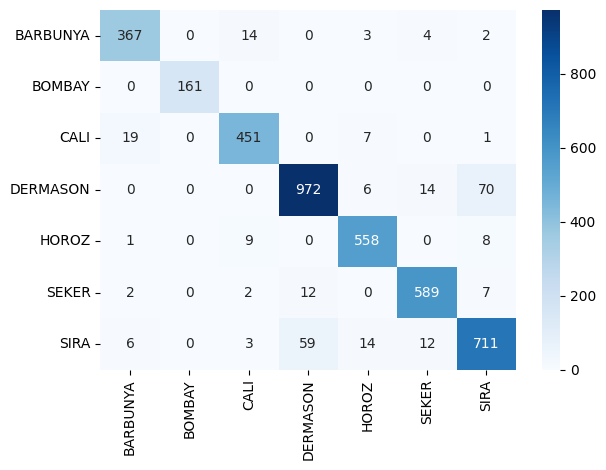

In [48]:
best_fit_test(svm_classifier_best, 4, "SVM")


With the best parameters, the SVM classifier improves on both the training score and the testing score which is the only one out of the five different classifiers. Compared to other classifiers, the SVC also does the best on classifying Demarson and Sira which is the main contributor to the error rate.


### SVM Learning Curve


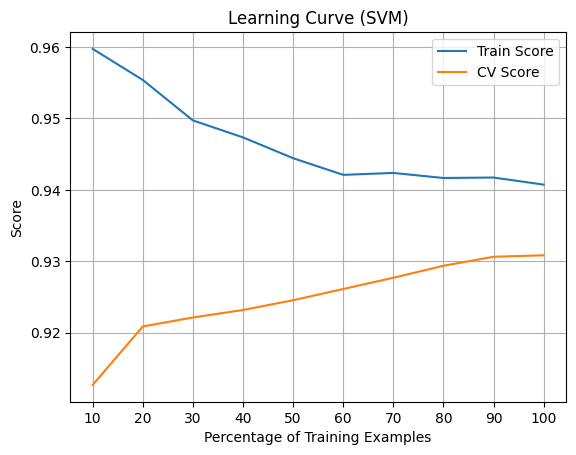

In [49]:
svm_classifier_learning = svm.SVC(
    random_state=42, C=svm_classifier_best.best_params_['C'],
    kernel=svm_classifier_best.best_params_['kernel'])
plot_learning_curve(svm_classifier_learning, "SVM")


From the above learning curve, a trend of convergence between the training score and the CV score is observed. This means that the SVM classifier is a good fit for this dataset. The final accuracy score is also the highest among all the classifiers.

Another interesting observation is that the `C` in the best parameters is over 20 which is quite big. This can be a proof to that the dataset is noisy. If we project the value inits validation curve, it shows that the SVC has to sacrifice a lot of margin and training set accuracy score to get a good overall accuracy score.


## k-Nearest Neighbors


### Pretuning


Train score 0.9415345859137189
Test score 0.9214005876591577
Train Confusion matrix


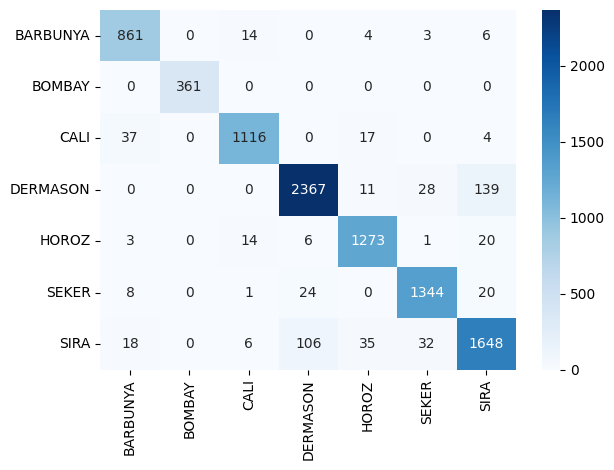

Test Confusion matrix


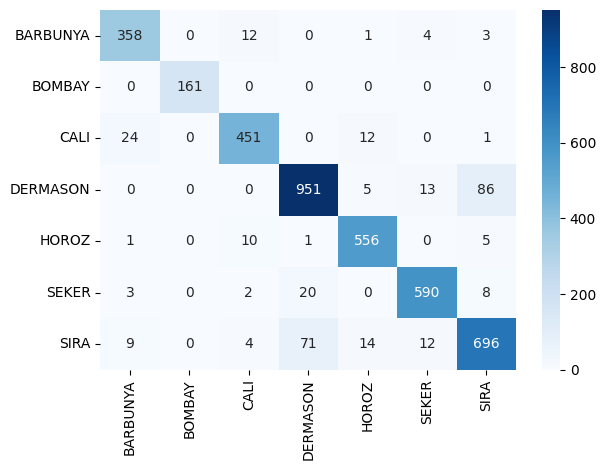

In [50]:
knn_classifier = KNeighborsClassifier()
default_fit_test(knn_classifier)


From what the confusion matrix is showing, the training score and the CV score is already pretty close to each other with the default case (n_neighbors=5, p=2) and is doing relatively well classify Demarson and Sira.


### Tune Number of Neighbors & Minkowski Power Parameter


Parameters to be tuned:

- n_neighbors ranging from [1, 201]
- p ranging from [1, 10]


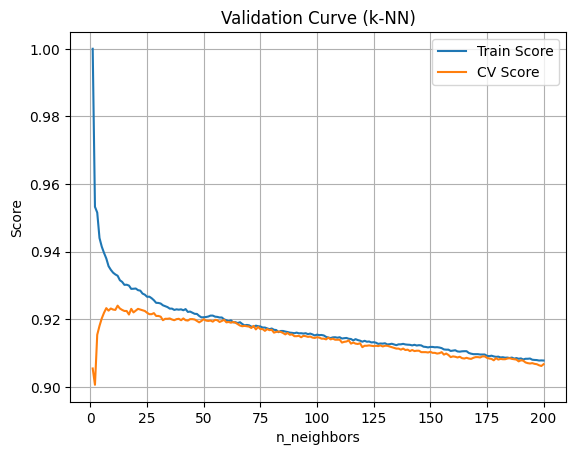

In [51]:
plot_validation_curve(
    knn_classifier, 'n_neighbors',
    np.arange(1, 201), "k-NN",
    default_xticks=True)


The above image shows the relationship of the training score and the CV score with the number of neighbours. The CV score reaches its maximum when the number of neighbours at a certain value and then starts to decrease together with the training score. The reason is likely to be the bias in the model which keeps increasing as the number of neighbours increases. Essentially, when the k is too small, it's more likely to overfit since the classifier is very sensitive to anomalies whereas when the k is too big, the classifier is going to underfit since it' slowly ignoring the local particularities.


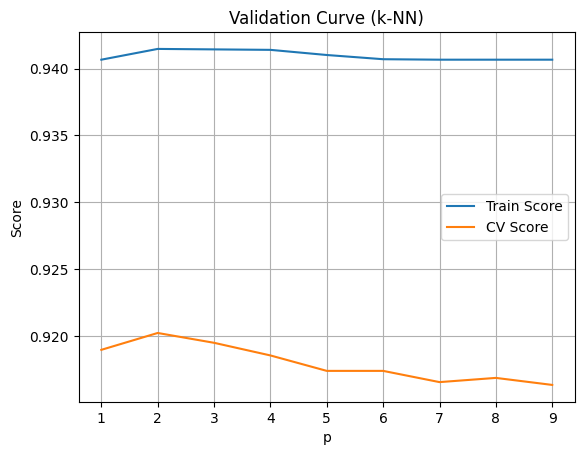

In [52]:
plot_validation_curve(knn_classifier, 'p', np.arange(1, 10), "k-NN")


The above image shows the relationship of the training score and the CV score when tuning the power parameter for the Minkowski distance function. The CV score reaches its maximum when the power parameter is 2 and then starts to decrease. 

In [53]:
param_grid = {
    'n_neighbors': np.arange(1, 201),
    'p': np.arange(1, 10)
}
knn_classifier_best = grid_search_and_best_fit(
    knn_classifier, param_grid, 5, "k-NN")


Best params for k-NN: {'n_neighbors': 12, 'p': 2}


Accuracy for best k-NN on train sets: 0.9319827857667682
Accuracy for best k-NN on test sets: 0.9253183153770813
Train Set with Best Params Confusion matrix


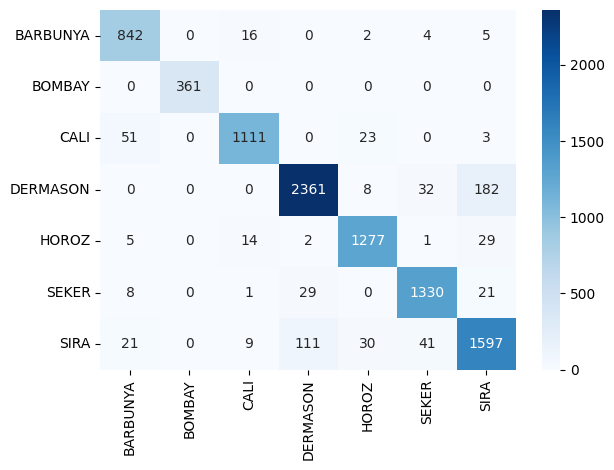

Test Set with Best Params Confusion matrix


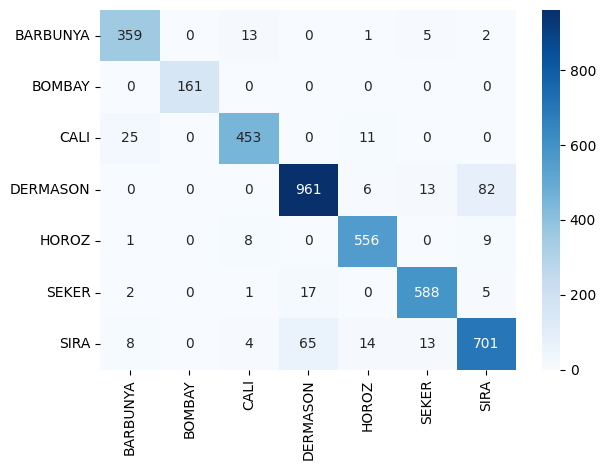

In [54]:
best_fit_test(knn_classifier_best, 5, "k-NN")


### k-Nearest Neighbors Learning Curve

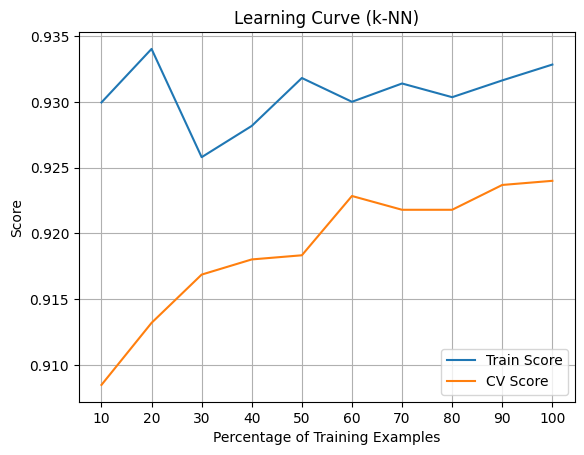

In [55]:
knn_classifier_learning = KNeighborsClassifier(
    n_neighbors=knn_classifier_best.best_params_['n_neighbors'],
    p=knn_classifier_best.best_params_['p'])
plot_learning_curve(knn_classifier_learning, "k-NN")


The learning curve for the k-NN classifier shows a trend of convergence between the training score and the CV score. This means that the k-NN classifier is a good fit for this dataset. The final accuracy score is also the second highest among all the classifiers.


## Time Comparison

In [68]:
classifiers: list[str] = ["DT", "ML NN", "SL NN", "Boosting", "SVM", "k-NN"]
y_ticks = np.arange(len(classifiers))
print(f"Training Time: {train_time}")
print(f"Inference Time: {infer_time}")
print(f"Accuracy: {classifier_accuracy}")

Training Time: [  213.96799898  4446.78909993  4132.04236674 36783.7377913
   477.41578937 12015.55802464]
Inference Time: [0.0013423  0.01333451 0.01094007 0.05291677 0.41717625 0.18325257]
Accuracy: [0.90058766 0.92360431 0.93364349 0.88442703 0.93266405 0.92531832]


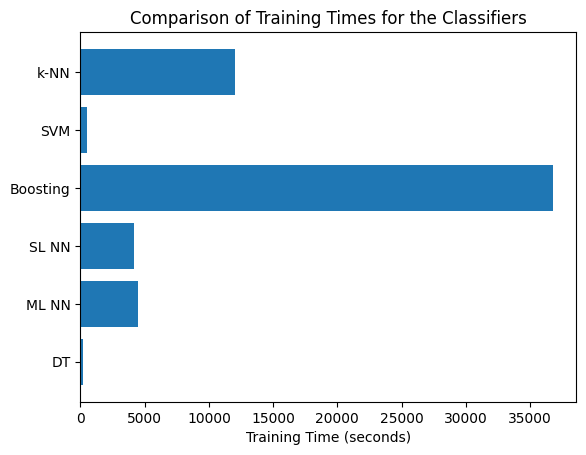

In [69]:
plt.figure()
plt.barh(y_ticks, train_time)
plt.gca().set_yticks(y_ticks)
plt.gca().set_yticklabels(classifiers)
plt.title('Comparison of Training Times for the Classifiers')
plt.xlabel('Training Time (seconds)')
plt.savefig('images/dry_bean/dry_bean_training_time.png', dpi=300, bbox_inches='tight')
plt.show()

For the Dry Bean dataset, Boosting and k-NN classifiers took the longest time. This is likely due to a large number neighbours for the knn classifier and a decent amount of complicated weak learners for the boosting classifier. Decision tree is trained the fastest as expected as the max depth of the tree is controlled using the max depth hyper-parameter. The neural network training times are also relatively high because the neural network needs to adjust the weight for each perceptron through backpropagation for gradient computation and the more layers/nodes there are in the NN, the longer it takes. SVM is relatively fast. This is probably due to the large miss-classification margin. This means that the constraint for SVM is relatively loose.


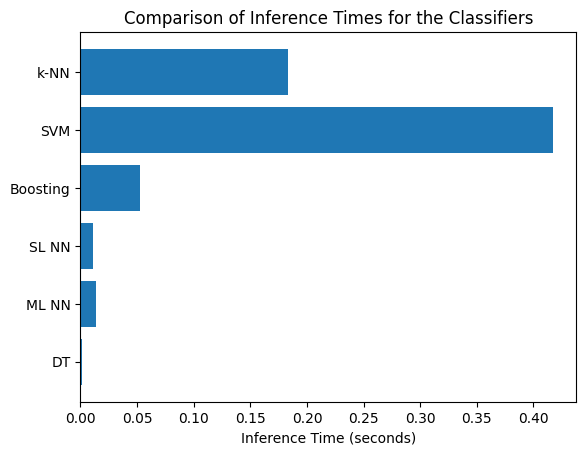

In [70]:
plt.figure()
plt.barh(y_ticks, infer_time)
plt.gca().set_yticks(y_ticks)
plt.gca().set_yticklabels(classifiers)
plt.title('Comparison of Inference Times for the Classifiers')
plt.xlabel('Inference Time (seconds)')
plt.savefig('images/dry_bean/dry_bean_infer_time.png', dpi=300, bbox_inches='tight')
plt.show()

Inference time for decision trees is also low as depth first search is tirvial for a tree. For the k-NN classifier, since the distance to each neighbor has to be computed, it will take some time when the number of neighbours taken into account is high. For Adaboost, as the inference is completed for each weak learner, it will take some time with a large number of weak learners. Both NN classifiers are relatively faster since the NN classifiers only need a single forward pass for each test case. What really surprises me is that the SVM takes the longest time to predict the testing set. A likely explanantion is that given how noisy this dataset is, the function that produces the maximum margin at the boundary layer might be very complicated and thus taking a lot of computing time.


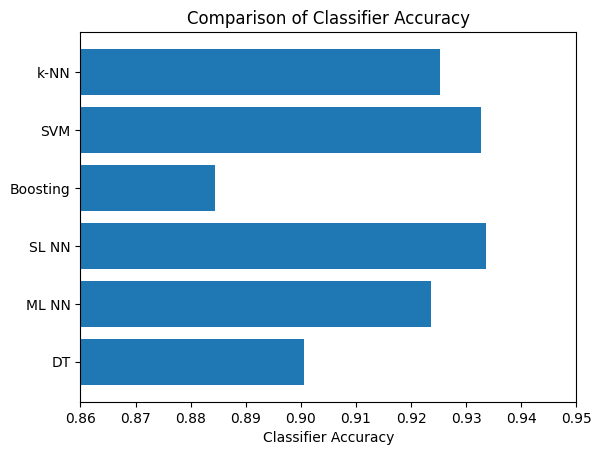

In [73]:
plt.figure()
plt.barh(y_ticks, classifier_accuracy)
plt.gca().set_yticks(y_ticks)
plt.gca().set_yticklabels(classifiers)
plt.title('Comparison of Classifier Accuracy')
plt.xlabel('Classifier Accuracy')
plt.gca().set_xlim(0.86, 0.95)
plt.savefig('images/dry_bean/dry_bean_accuracy.png', dpi=300, bbox_inches='tight')
plt.show()

For the dry bean dataset, all classifier performs relatively similar with an accruacy score ranging from 88% to 93%. A relatively high accuracy score with both neural network and k-NN classifier show that the dataset may be linearly separable. However the lower accuracy score of boosting and decision tree classifier suggests that the data is also quite noisy.
